In [21]:
import os
import numpy as np
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
import pywt


In [22]:
# Función para normalizar señales
def normalize_signal(signal):
    return (signal - np.min(signal, axis=0)) / (np.max(signal, axis=0) - np.min(signal, axis=0))

# Funciones para extracción de características
def compute_rms(segment):
    return np.sqrt(np.mean(segment**2, axis=0))

def compute_mav(segment):
    return np.mean(np.abs(segment), axis=0)

def compute_mean(segment):
    return np.mean(segment, axis=0)

def compute_max(segment):
    return np.max(segment, axis=0)

def compute_min(segment):
    return np.min(segment, axis=0)

def compute_std(segment):
    return np.std(segment, axis=0)

def extract_wavelet_features(signal, wavelet='sym4', level=4):
    """
    Extrae características basadas en la transformada wavelet discreta
    """
    coeffs = pywt.wavedec(signal, wavelet, level=level, axis=0)
    features = []
    for coeff in coeffs:
        features.extend([np.mean(coeff, axis=0), np.std(coeff, axis=0),
                         np.max(coeff, axis=0), np.min(coeff, axis=0)])
    return np.hstack(features)

In [23]:
# Procesamiento de datos
def process_and_extract_features(data_dir):
    """
    Procesa los datos, normaliza las señales y extrae características
    """
    features = []
    labels = []

    for file_name in os.listdir(data_dir):
        if file_name.endswith(".mat"):
            # Cargar archivo
            file_path = os.path.join(data_dir, file_name)
            data = loadmat(file_path)

            # Validar la existencia de matrices relevantes
            if not all(key in data for key in ['restimulus', 'rerepetition', 'emg', 'acc', 'glove', 'inclin']):
                print(f"Archivo {file_name} omitido: faltan matrices relevantes.")
                continue
            
            restimulus = data['restimulus'].flatten()
            rerepetition = data['rerepetition'].flatten()
            emg = normalize_signal(data['emg'])
            acc = normalize_signal(data['acc'])
            glove = normalize_signal(data['glove'])
            inclin = normalize_signal(data['inclin'])

            # Iterar sobre valores únicos de restimulus
            for restimulus_value in np.unique(restimulus):
                if restimulus_value == 0:
                    continue  # Ignorar filas con restimulus igual a 0
                
                # Iterar sobre repeticiones para cada restimulus
                for repetition in range(1, 7):
                    idx = (restimulus == restimulus_value) & (rerepetition == repetition)
                    
                    if np.sum(idx) == 0:
                        continue  # Si no hay datos, saltar
                    
                    # Segmentar señales
                    emg_segment = emg[idx, :]
                    acc_segment = acc[idx, :]
                    glove_segment = glove[idx, :]
                    inclin_segment = inclin[idx, :]

                    # Extraer características
                    emg_features = np.hstack([compute_rms(emg_segment), compute_mav(emg_segment),
                                              compute_mean(emg_segment), compute_max(emg_segment),
                                              compute_min(emg_segment), compute_std(emg_segment),
                                              extract_wavelet_features(emg_segment)])
                    acc_features = np.hstack([compute_rms(acc_segment), compute_mav(acc_segment),
                                              compute_mean(acc_segment), compute_max(acc_segment),
                                              compute_min(acc_segment), compute_std(acc_segment),
                                              extract_wavelet_features(acc_segment)])
                    glove_features = np.hstack([compute_rms(glove_segment), compute_mav(glove_segment),
                                                compute_mean(glove_segment), compute_max(glove_segment),
                                                compute_min(glove_segment), compute_std(glove_segment),
                                                extract_wavelet_features(glove_segment)])
                    inclin_features = np.hstack([compute_rms(inclin_segment), compute_mav(inclin_segment),
                                                 compute_mean(inclin_segment), compute_max(inclin_segment),
                                                 compute_min(inclin_segment), compute_std(inclin_segment),
                                                 extract_wavelet_features(inclin_segment)])

                    # Concatenar características y etiquetas
                    all_features = np.hstack([emg_features, acc_features, glove_features, inclin_features])
                    features.append(all_features)
                    labels.append(restimulus_value)

    # Convertir a matrices de NumPy
    features = np.array(features)
    labels = np.array(labels)
    return features, labels

In [24]:
# Construcción del modelo AlexNet modificado
def build_modified_alexnet(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv1D(64, kernel_size=11, strides=2, padding='same', activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling1D(pool_size=2, strides=2, padding='same'),
        layers.Conv1D(128, kernel_size=5, padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        layers.BatchNormalization(),
        layers.MaxPooling1D(pool_size=2, strides=2, padding='same'),
        layers.Conv1D(256, kernel_size=3, padding='same', activation='relu'),
        layers.Conv1D(512, kernel_size=3, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling1D(pool_size=2, strides=2, padding='same'),
        layers.Flatten(),
        layers.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax'),
    ])
    return model

In [25]:
# Entrenamiento del modelo
def train_model(model, x_train, y_train, x_val, y_val, batch_size=32, epochs=50, learning_rate=0.0001):
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
    model.compile(optimizer=optimizers.Adam(learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    history = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_data=(x_val, y_val),
                        callbacks=[early_stopping, reduce_lr])
    return history

In [26]:
# Evaluación del modelo
def evaluate_model(model, x_test, y_test, class_names):
    y_pred = model.predict(x_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)
    cm = confusion_matrix(y_true, y_pred_classes)
    print("\nClassification Report:\n", classification_report(y_true, y_pred_classes, target_names=class_names))
    return cm

In [27]:
# Visualización de la matriz de confusión
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title("Matriz de Confusión")
    plt.xlabel("Predicción")
    plt.ylabel("Etiqueta Verdadera")
    plt.show()

Epoch 1/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 71s 837ms/step - accuracy: 0.3157 - loss: 25.1375 - val_accuracy: 0.0597 - val_loss: 16.5227 - learning_rate: 1.0000e-04
Epoch 2/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 69s 835ms/step - accuracy: 0.8350 - loss: 13.0974 - val_accuracy: 0.1087 - val_loss: 12.8353 - learning_rate: 1.0000e-04
Epoch 3/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 68s 828ms/step - accuracy: 0.9453 - loss: 9.5524 - val_accuracy: 0.0643 - val_loss: 10.4905 - learning_rate: 1.0000e-04
Epoch 4/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 67s 822ms/step - accuracy: 0.9647 - loss: 7.4694 - val_accuracy: 0.1776 - val_loss: 8.5235 - learning_rate: 1.0000e-04
Epoch 5/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 73s 893ms/step - accuracy: 0.9714 - loss: 6.0339 - val_accuracy: 0.4625 - val_loss: 6.7003 - learning_rate: 1.0000e-04
Epoch 6/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 69s 843ms/step - accuracy: 0.9835 - loss: 4.9578 - val_accuracy: 0.8055 - val_loss: 4.9739 - learning_rate: 1.0000e-04
Epoch 7/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 69s 840ms/step 

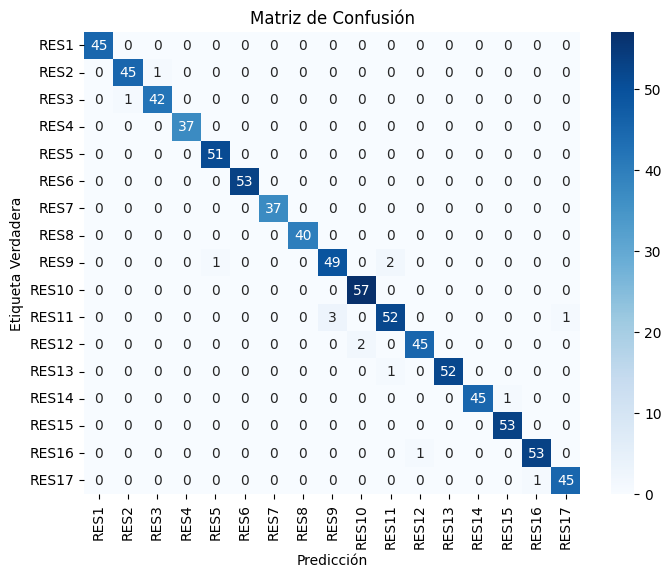

In [28]:
# Ejecución
data_dir = "C:\\Users\\fabia\\Desktop\\proceso_1"
features, labels = process_and_extract_features(data_dir)
features = np.expand_dims(features, axis=-1)
labels = to_categorical(labels - 1, num_classes=17)

x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

input_shape = x_train.shape[1:]
num_classes = y_train.shape[1]

model = build_modified_alexnet(input_shape, num_classes)
history = train_model(model, x_train, y_train, x_val, y_val)

cm = evaluate_model(model, x_test, y_test, class_names=[f"RES{i}" for i in range(1, 18)])
plot_confusion_matrix(cm, class_names=[f"RES{i}" for i in range(1, 18)])